In [24]:
from preprocessor import *
import dateutil
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

# predict homicides against other crimes
'''
Load some data and do some cleaning
'''
crimes = pd.read_csv("~/Documents/datasets/crime.csv")
crimes = crimes.sample(frac=0.01, random_state=1)
crimes.drop(['IncidntNum','Descript','X','Y','PdId'],1,inplace=True)
crimes = crimes.dropna()
prep = Preprocessor(crimes)
crimes.shape
#prep.overview()

(14358, 8)

In [25]:
# Convert date from string to date times
crimes['Date'] = crimes['Date'].apply(dateutil.parser.parse, dayfirst=True)


In [26]:
#Will get a better way to do this later
crimes['WrongTime'] = pd.to_datetime(crimes['Time'])
crimes['hours'] = crimes['WrongTime'].apply(lambda x: x.time())
crimes['Hour'] = crimes['hours'].apply(lambda x: x.hour)

In [27]:
crimes["Month"] = crimes["Date"].dt.month_name().astype(object)
crimes["Year"] = crimes["Date"].dt.year.astype(object)
crimes = crimes.drop(['WrongTime','hours'],axis=1)
crimes['Hour'] = crimes['Hour'].astype(object)

In [28]:
crimes['Robbery'] = crimes.Category.apply(lambda x: x =='ROBBERY')

In [29]:
crimes.head()

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Location,Hour,Month,Year,Robbery
378390,VANDALISM,Thursday,2007-06-09,16:00,CENTRAL,NONE,MARKET ST / PINE ST,"(37.7924047319625, -122.397387796127)",16,June,2007,False
1229013,OTHER OFFENSES,Thursday,2015-10-12,17:47,BAYVIEW,"ARREST, BOOKED",DONAHUE ST / KIRKWOOD AV,"(37.7275640720341, -122.371274317443)",17,October,2015,False
591872,LARCENY/THEFT,Tuesday,2010-02-03,19:30,SOUTHERN,NONE,HOWARD ST / MAIN ST,"(37.7906117204093, -122.393413306041)",19,February,2010,False
39823,LARCENY/THEFT,Sunday,2014-07-13,18:15,MISSION,NONE,MISSION ST / 14TH ST,"(37.7682726763619, -122.419983447697)",18,July,2014,False
492724,OTHER OFFENSES,Wednesday,2010-10-03,15:00,SOUTHERN,NONE,800 Block of BRYANT ST,"(37.775420706711, -122.403404791479)",15,October,2010,False


In [30]:
crimes.Robbery.value_counts(normalize=True)

False    0.973604
True     0.026396
Name: Robbery, dtype: float64

In [37]:
# group by Sex, Pclass, and Title 
grouped = crimes.groupby(['DayOfWeek','Robbery'])  # view the median Age by the grouped features 
grouped.PdDistrict.count()

DayOfWeek  Robbery
Friday     False      2086
           True         62
Monday     False      1953
           True         70
Saturday   False      2031
           True         50
Sunday     False      1925
           True         54
Thursday   False      1961
           True         49
Tuesday    False      1982
           True         56
Wednesday  False      2041
           True         38
Name: PdDistrict, dtype: int64

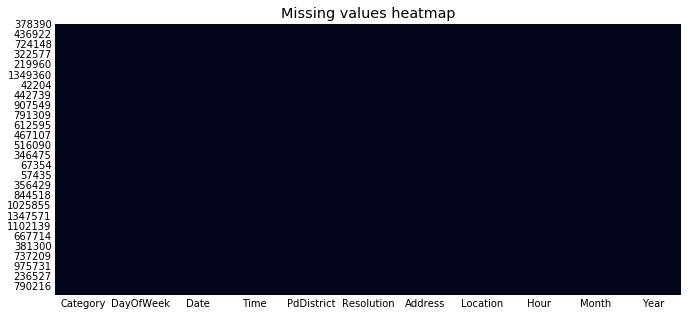

In [5]:
tn = crimes.isnull()
plt.figure(figsize=(10,5))
sns.heatmap(tn,cbar=False).set_title("Missing values heatmap");

In [30]:
crimes = crimes.drop(['Date'],axis=1)

In [ ]:
X.shape

In [20]:
X_train, X_test, y_train ,y_test = train_test_split(X, y, random_state= 42,test_size = 0.2)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from time import time

clf_C = RandomForestClassifier(n_estimators = 100,max_depth = 50,random_state=82)

In [24]:
print('Random Forest...')
start = time()
clf_C.fit(X_train, y_train)
end = time()
print('Trained model in {:3f} seconds...'.format(end - start))
y_pred_C = clf_C.predict(X_test)
# print classification report for random forest
print(f'Classification report for Random Forest :\n{classification_report(y_test, y_pred_C)}')
print('')


Random Forest...
Trained model in 37.535889 seconds...
Classification report for Random Forest :
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00         4
                    ASSAULT       0.50      0.01      0.02       239
                    BRIBERY       0.00      0.00      0.00         1
                   BURGLARY       0.00      0.00      0.00        96
         DISORDERLY CONDUCT       0.00      0.00      0.00        16
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00        11
              DRUG/NARCOTIC       0.56      0.22      0.31       161
                DRUNKENNESS       0.00      0.00      0.00        11
               EMBEZZLEMENT       0.00      0.00      0.00         3
                  EXTORTION       0.00      0.00      0.00         1
            FAMILY OFFENSES       0.00      0.00      0.00         3
     FORGERY/COUNTERFEITING       0.00      0.00      0.00        22
     

In [5]:
district = crimes.groupby("PdDistrict").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_district = pd.DataFrame(district['PdDistrict'].value_counts())
total = len(district)
df_district['Percentage'] = (df_district['PdDistrict'] / total) * 100
df_district

,PdDistrict,Percentage
SOUTHERN,266017,18.527531
MISSION,191046,13.305957
NORTHERN,170317,11.862225
CENTRAL,147268,10.256910
BAYVIEW,141810,9.876772
TENDERLOIN,131404,9.152016
INGLESIDE,124938,8.701672
TARAVAL,105333,7.336225
PARK,82017,5.712314
RICHMOND,75643,5.268378


In [6]:

crimes.dtypes

Category              object
DayOfWeek             object
Date          datetime64[ns]
Time                  object
PdDistrict            object
Resolution            object
Address               object
Location              object
Hour                  object
Month                 object
Year                   int64
dtype: object

In [10]:
category = crimes.groupby("Category").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_category = pd.DataFrame(category['Category'].value_counts())
total = len(category)
df_category['Percentage'] = (df_category['Category'] / total) * 100
df_category

,Category,Percentage
LARCENY/THEFT,3070,21.381808
OTHER OFFENSES,2064,14.375261
NON-CRIMINAL,1595,11.108790
ASSAULT,1251,8.712913
VANDALISM,809,5.634489
DRUG/NARCOTIC,772,5.376793
VEHICLE THEFT,629,4.380833
WARRANTS,629,4.380833
SUSPICIOUS OCC,578,4.025630
BURGLARY,562,3.914194


In [8]:
year = crimes.groupby("Year").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_year = pd.DataFrame(year['Year'].value_counts())
total = len(year)
df_year['Percentage'] = (df_year['Year'] / total) * 100
df_year

,Year,Percentage
2015,156530,10.901989
2013,152806,10.642620
2016,150450,10.478530
2014,150130,10.456243
2008,141311,9.842018
2012,140847,9.809701
2009,139860,9.740958
2007,137639,9.586270
2010,133523,9.299600
2011,132697,9.242070


In [9]:
month = crimes.groupby("Month").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_month = pd.DataFrame(month['Month'].value_counts())
total = len(month)
df_month['Percentage'] = (df_month['Month'] / total) * 100
df_month

,Month,Percentage
January,130058,9.058270
October,124204,8.650551
August,122969,8.564535
March,121643,8.472182
May,121175,8.439587
July,120519,8.393898
September,120491,8.391948
April,117129,8.157792
June,116037,8.081736
November,115878,8.070662


In [10]:
day = crimes.groupby("DayOfWeek").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_day = pd.DataFrame(day['DayOfWeek'].value_counts())
total = len(day)
df_day['Percentage'] = (df_day['DayOfWeek'] / total) * 100
df_day['AboveAverage'] = df_day['DayOfWeek'] > df_day['DayOfWeek'].mean()
df_day

,DayOfWeek,Percentage,AboveAverage
Friday,218046,15.186451,True
Saturday,210294,14.646540,True
Wednesday,208769,14.540327,True
Tuesday,203128,14.147443,False
Thursday,203096,14.145215,False
Monday,198835,13.848445,False
Sunday,193625,13.485579,False


In [11]:
hour = crimes.groupby("Hour").filter(lambda x: ((len(x) / len(crimes)) * 100) > 0)
df_hour = pd.DataFrame(hour['Hour'].value_counts())
total = len(hour)
df_hour['Percentage'] = (df_hour['Hour'] / total) * 100
#df_hour['AboveAverage'] = df_hour['Hour'] > df_hour['Hour'].mean()
df_hour

,Hour,Percentage
18,90939,6.333712
17,87997,6.128808
12,85156,5.930939
16,82052,5.714751
19,81897,5.703956
15,78473,5.465481
0,75408,5.252011
20,74896,5.216351
22,73552,5.122744
14,72474,5.047664


In [12]:
# TASK: plot bar graphs of the dfs above

In [13]:
crimes.head()

,Category,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,Location,Hour,Month,Year
0,NON-CRIMINAL,Monday,2015-01-19,14:00,MISSION,NONE,18TH ST / VALENCIA ST,"(37.7617007179518, -122.42158168137)",14,January,2015
1,ROBBERY,Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",15,January,2015
2,ASSAULT,Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",15,January,2015
3,SECONDARY CODES,Sunday,2015-01-02,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,"(37.7841907151119, -122.414406029855)",15,January,2015
4,VANDALISM,Tuesday,2015-01-27,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,"(37.8004687042875, -122.431118543788)",19,January,2015


In [15]:

crimes = pd.read_csv('~/Documents/datasets/crime.csv',nrows=100000)

# custom multicolumn transformer

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode
        
    def fit(self, X,y=None):
        return self # not relevant
    def transform(self, X):
        ''' 
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all columns in X
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
             for colname,col in enumerate(output):
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    
    def fit_transform(self, X ,y=None):
        return self.fit(X,y).transform(X)
    
### you can also use the above class as shown in the line below ###
#MultiColumnLabelEncoder(columns = cat_attributes).fit_transform(olympics)
                    
def column_types(df):
    cat_cols = []
    num_cols = []
    
    for y in df.columns:
        if (df[y].dtype == object):
            cat_cols.append(y)
        else:
            num_cols.append(y)
    
    return cat_cols, num_cols

# Handling categorical attributes
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

class MyLabelBinarizer():
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer( *args, **kwargs)
    def fit(self, x, y = 0):
        self.encoder.fit(x)
        return self
    def transform(self,x, y=0):
        return self.encoder.transform(x)

cat_attributes ,num_attributes = column_types(crimes)

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attributes)),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attributes)),
    ('label_encoder', MultiColumnLabelEncoder())
]) 

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

prepared = full_pipeline.fit_transform(crimes)

labels = crimes["Category"]

X_train, X_test, y_train ,y_test = train_test_split(prepared, labels, random_state= 0,test_size = 0.25)
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
label_rf = forest.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


Accuracy on the training subset: 0.985773
Accuracy on the testing subset: 0.709840


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


'''
Load some data and do some cleaning
#NOTE: This dataset contains one million rows so it takes a considerable time 
        to load depending on your computing power and memory resources
'''
data = pd.read_csv('~/Documents/datasets/crime.csv',nrows=100000)

data = data.sample(frac=0.05, random_state=1)
to_drop = ['IncidntNum','Category','PdId']
X_all = data.drop(to_drop,1)
y_all = data["Category"]


#Standardising the data
num_features = ['X','Y']
cat_features = ['Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution',
       'Address', 'Location']

scaled_data = StandardScaler().fit_transform(X_all[num_features])
scaled = pd.DataFrame(scaled_data,columns = num_features)
dummies = pd.get_dummies(X_all[cat_features],prefix = [col for col, col_data in X_all[cat_features].iteritems()])


len(cat_features)

pca=PCA(n_components=300)

x_pca = pca.fit_transform(dummies)
x_pca = pd.DataFrame(x_pca)

df = x_pca.join(scaled)

X_train, X_test, y_train ,y_test = train_test_split(df, y_all, random_state= 0,test_size = 0.25)
pca.explained_variance_ratio_.sum()

NameError: name 'pd' is not defined

In [ ]:
x_pca.shape

In [ ]:
forest = RandomForestClassifier(n_jobs=-1,max_depth=100,n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
label_rf = forest.predict(X_test)
print('Accuracy on the training subset: {:3f}'.format(forest.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(forest.score(X_test, y_test)))


In [ ]:
%matplotlib inline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score


clf_A = LogisticRegression(solver='lbfgs',random_state = 42,multi_class='auto')
clf_B = SVC(random_state = 912,kernel = 'rbf',gamma = 'scale')
clf_C = RandomForestClassifier(n_estimators = 100,max_depth = 10,random_state=82)
clf_D = xgb.XGBClassifier(seed=82)

print('Logistic Regresssion...')
start  = time()
clf_A.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_A = clf_A.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_A,average = 'macro')))
#print(classification_report(y_test,y_pred_A))
print('Accuracy on the training subset: {:3f}'.format(clf_A.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_A.score(X_test, y_test)))
print('')

print('Support Vector Machine...')
start  = time()
clf_B.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_B = clf_B.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_B,average = 'macro')))
print('Accuracy on the training subset: {:3f}'.format(clf_B.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_B.score(X_test, y_test)))
print('')

print('Random Forest...')
start = time()
clf_C.fit(X_train, y_train)
end = time()
print('Done in {} seconds...'.format(end - start))
y_pred_C = clf_C.predict(X_test)
print("F1 Score: {}".format(f1_score(y_test,y_pred_C,average = 'macro')))
#print(classification_report(y_all,y_pred_C))
print('Accuracy on the training subset: {:3f}'.format(clf_C.score(X_train, y_train)))
print('Accuracy on the testing subset: {:3f}'.format(clf_C.score(X_test, y_test)))
print('')


In [ ]:
import dateutil


data = pd.read_csv('~/Documents/datasets/crime.csv',nrows=100000)
data['Date'] = data['Date'].apply(dateutil.parser.parse, dayfirst=True)
data['Month'] = data['Date'].apply(lambda x: x.month)
data.dtypes

In [ ]:
from dateutil import parser, rrule
from datetime import datetime, time, date
import calendar


data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

data.head()

In [ ]:
data['PdDistrict'].unique()
#x = pd.DataFrame()
group_by_day = data.groupby(['DayOfWeek','PdDistrict'])
count_group_by_day = group_by_day.size().unstack()
count_group_by_day
# do a heatmap of day of week and crime in different districts
#use the dateutils lib to properly parse dates and times

In [ ]:
crimes_by_district = data.pivot_table(index='Date', columns='PdDistrict', values='IncidntNum', aggfunc='count')
crimes_by_district.head(20)


In [ ]:
x = joblib.load('crime.pkl')

In [ ]:
x.head()

In [ ]:
y = x[x['Year'] == 2007].groupby(['Month','PdDistrict'])['Date'].count()
y